In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [35]:
wine_data = pd.read_csv('./winequality-red.csv')

In [36]:

print("\nMissing values:")
print(wine_data.isnull().sum())

print("\nStatistical Summary:")
wine_data.describe()


Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Statistical Summary:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


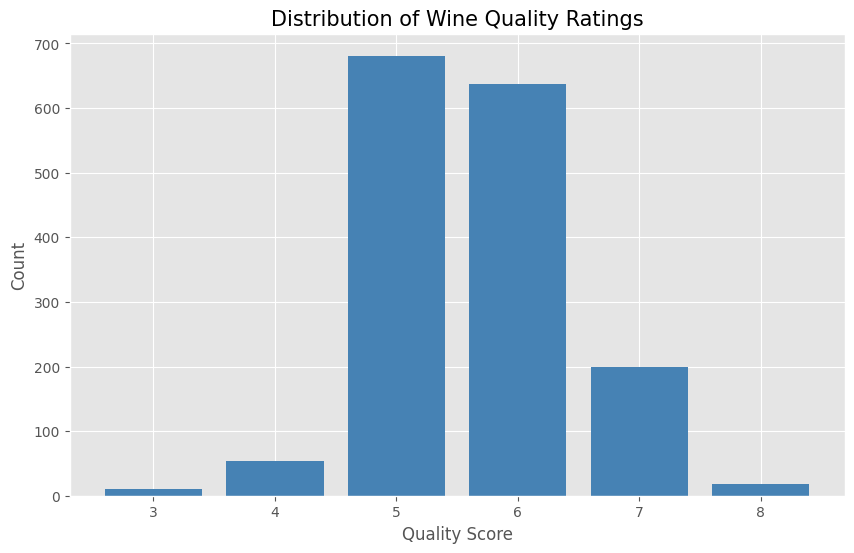

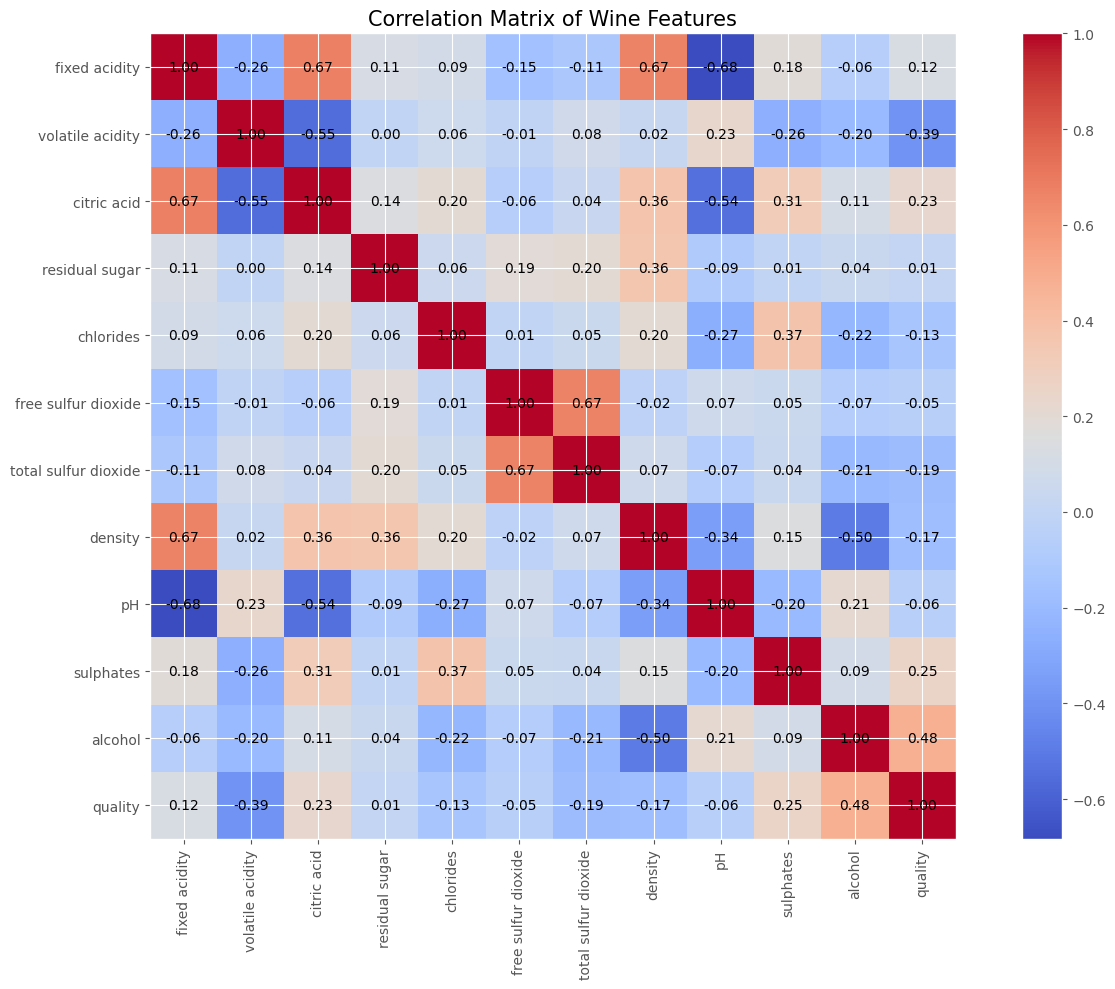

In [37]:
plt.figure(figsize=(10, 6))
quality_counts = wine_data['quality'].value_counts().sort_index()
plt.bar(quality_counts.index, quality_counts.values, color='steelblue')
plt.title('Distribution of Wine Quality Ratings', fontsize=15)
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(quality_counts.index)
plt.show()

plt.figure(figsize=(14, 10))
corr = wine_data.corr()
im = plt.imshow(corr, cmap='coolwarm')
plt.colorbar(im)
plt.title('Correlation Matrix of Wine Features', fontsize=15)


for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = plt.text(j, i, f'{corr.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


## Preprocessing

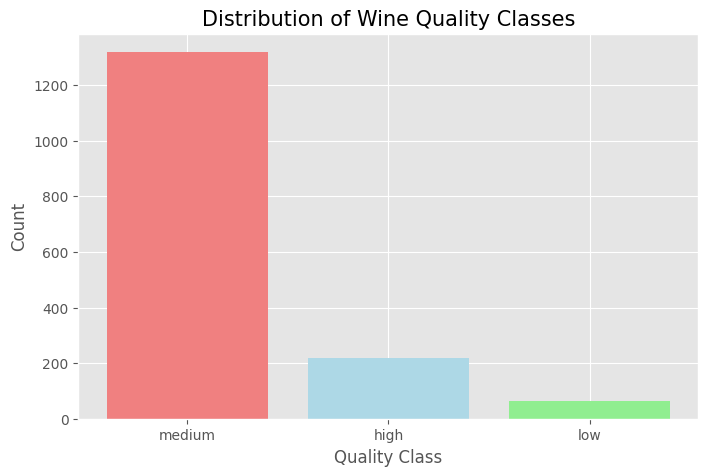

In [38]:

def quality_to_class(quality):
    if quality <= 4:
        return 'low'
    elif quality <= 6:
        return 'medium'
    else:
        return 'high'

wine_data['quality_class'] = wine_data['quality'].apply(quality_to_class)

plt.figure(figsize=(8, 5))
class_counts = wine_data['quality_class'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Distribution of Wine Quality Classes', fontsize=15)
plt.xlabel('Quality Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
wine_data['quality_class_encoded'] = le.fit_transform(wine_data['quality_class'])

In [39]:
X = wine_data.drop(['quality', 'quality_class', 'quality_class_encoded'], axis=1)
y = wine_data['quality_class_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1199, 11)
Testing set shape: (400, 11)


In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Before scaling:")
print(X_train.iloc[0].values)
print("\nAfter scaling:")
print(X_train_scaled[0])

Before scaling:
[ 9.3    0.27   0.41   2.     0.091  6.    16.     0.998  3.28   0.7
  9.7  ]

After scaling:
[ 0.59223682 -1.43809536  0.71381002 -0.3755152   0.07883581 -0.93510401
 -0.91357455  0.66659142 -0.22451169  0.27088437 -0.68606713]


## Classification Models

In [41]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
  
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\n{'-'*50}")
    print(f"Model: {model_name}")
    print(f"{'-'*50}")
    print(f"Cross-validation Mean Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.colorbar()
    
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return accuracy, cv_scores.mean()

model_results = {}



--------------------------------------------------
Model: Logistic Regression
--------------------------------------------------
Cross-validation Mean Accuracy: 0.8440 (±0.0231)
Test Accuracy: 0.8275

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.30      0.39        54
           1       0.00      0.00      0.00        16
           2       0.85      0.95      0.90       330

    accuracy                           0.83       400
   macro avg       0.47      0.42      0.43       400
weighted avg       0.78      0.83      0.80       400



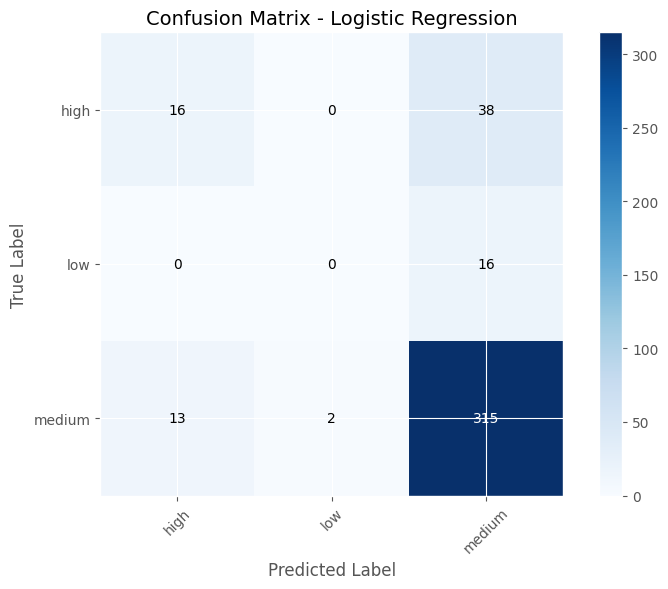

In [42]:

lr = LogisticRegression(max_iter=1000, random_state=42)
accuracy_lr, cv_lr = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
model_results["Logistic Regression"] = (accuracy_lr, cv_lr)


--------------------------------------------------
Model: K-Nearest Neighbors
--------------------------------------------------
Cross-validation Mean Accuracy: 0.8324 (±0.0274)
Test Accuracy: 0.8350

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.49        54
           1       0.00      0.00      0.00        16
           2       0.87      0.94      0.90       330

    accuracy                           0.83       400
   macro avg       0.48      0.46      0.47       400
weighted avg       0.79      0.83      0.81       400



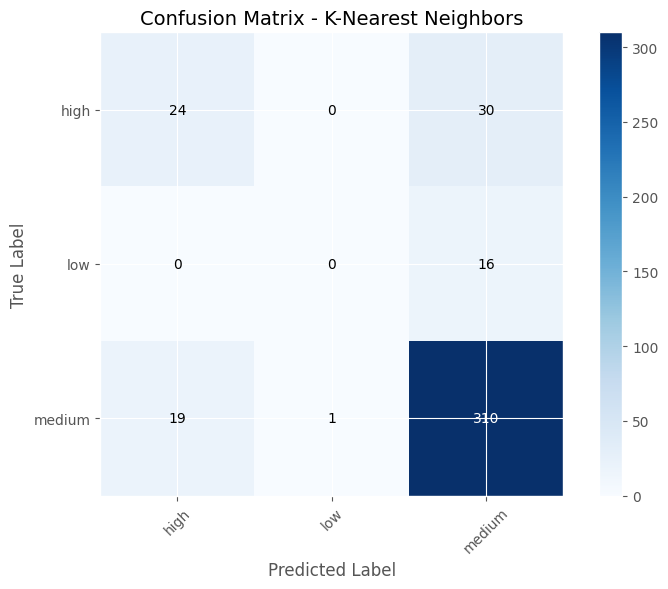

In [43]:

knn = KNeighborsClassifier()
accuracy_knn, cv_knn = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test, "K-Nearest Neighbors")
model_results["K-Nearest Neighbors"] = (accuracy_knn, cv_knn)


--------------------------------------------------
Model: Decision Tree
--------------------------------------------------
Cross-validation Mean Accuracy: 0.8157 (±0.0269)
Test Accuracy: 0.8175

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        54
           1       0.07      0.06      0.06        16
           2       0.89      0.90      0.89       330

    accuracy                           0.82       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.81      0.82      0.82       400



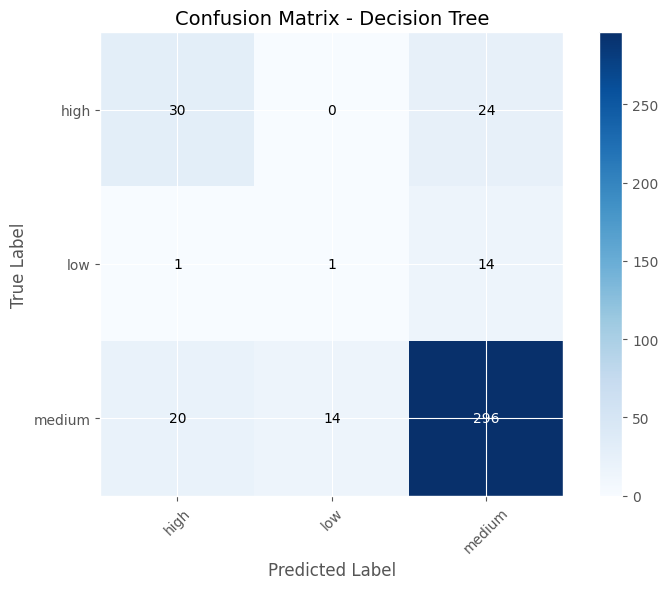

In [44]:
# 3. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
accuracy_dt, cv_dt = evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")
model_results["Decision Tree"] = (accuracy_dt, cv_dt)


--------------------------------------------------
Model: Random Forest
--------------------------------------------------
Cross-validation Mean Accuracy: 0.8616 (±0.0231)
Test Accuracy: 0.8550

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        54
           1       0.00      0.00      0.00        16
           2       0.88      0.95      0.92       330

    accuracy                           0.85       400
   macro avg       0.51      0.48      0.49       400
weighted avg       0.81      0.85      0.83       400



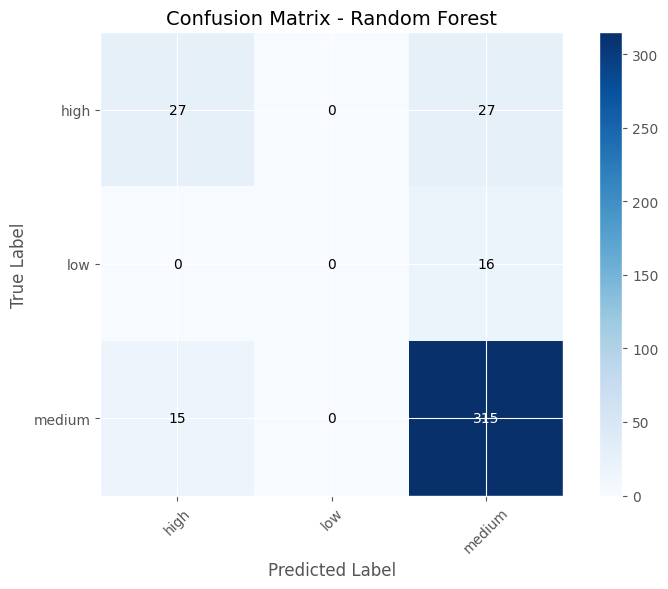

In [45]:
rf = RandomForestClassifier(random_state=42)
accuracy_rf, cv_rf = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
model_results["Random Forest"] = (accuracy_rf, cv_rf)


--------------------------------------------------
Model: Support Vector Machine
--------------------------------------------------
Cross-validation Mean Accuracy: 0.8432 (±0.0190)
Test Accuracy: 0.8375

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.26      0.36        54
           1       0.00      0.00      0.00        16
           2       0.85      0.97      0.91       330

    accuracy                           0.84       400
   macro avg       0.49      0.41      0.42       400
weighted avg       0.78      0.84      0.80       400



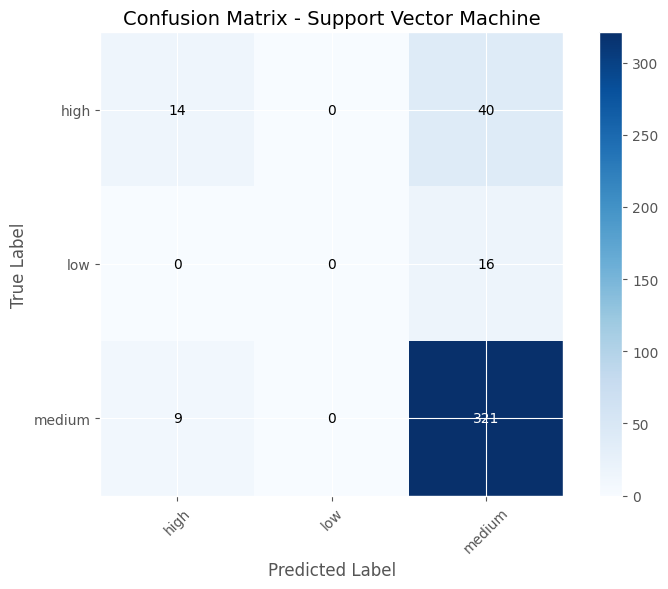

In [46]:
svm = SVC(random_state=42)
accuracy_svm, cv_svm = evaluate_model(svm, X_train_scaled, X_test_scaled, y_train, y_test, "Support Vector Machine")
model_results["Support Vector Machine"] = (accuracy_svm, cv_svm)

In [49]:
models_df = pd.DataFrame(model_results, index=['Test Accuracy', 'CV Accuracy']).T.sort_values('Test Accuracy', ascending=False)

print("\nModel Performance Summary (sorted by Test Accuracy):")
print(models_df)


Model Performance Summary (sorted by Test Accuracy):
                        Test Accuracy  CV Accuracy
Random Forest                  0.8550     0.861576
Support Vector Machine         0.8375     0.843218
K-Nearest Neighbors            0.8350     0.832368
Logistic Regression            0.8275     0.844038
Decision Tree                  0.8175     0.815718


In [51]:
rf.fit(X_train_scaled, y_train)


importances = rf.feature_importances_
feature_names = X.columns


indices = np.argsort(importances)[::-1]


print("Feature Importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Feature Importances:
alcohol: 0.1574
volatile acidity: 0.1263
sulphates: 0.1012
citric acid: 0.0890
density: 0.0854
total sulfur dioxide: 0.0820
fixed acidity: 0.0810
chlorides: 0.0795
residual sugar: 0.0706
pH: 0.0666
free sulfur dioxide: 0.0610
